# Predicting Horse Survial - Colic

Colic can be a very serious condition in horses. If unresolved it can cause death. Having lived with horses, colic is no laughing matter. You spend hours monitoring your horse hoping to hear gut sounds, for them to poop, and an interest in eating. It is quiete nerve racking. The bond between you and your horse is very special and can span for decades. This project is obviously personal to me. Being able to predict the outcome provides me with a strange piece of comfort. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
colic = pd.read_csv("horse.csv")

In [3]:
colic.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [4]:
colic.dtypes

surgery                   object
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube          object
nasogastric_reflux        object
nasogastric_reflux_ph    float64
rectal_exam_feces         object
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
abdomo_protein           float64
outcome                   object
surgical_lesion           object
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                   object
dtype: object

## EDA

### View Missing Data

In [5]:
# show number of rows and columns
colic.shape

(299, 28)

In [6]:
# see percentage of missing data 
colic.isnull().sum() * 100 / len(colic)

surgery                   0.000000
age                       0.000000
hospital_number           0.000000
rectal_temp              20.066890
pulse                     8.026756
respiratory_rate         19.397993
temp_of_extremities      18.729097
peripheral_pulse         23.076923
mucous_membrane          15.719064
capillary_refill_time    10.702341
pain                     18.394649
peristalsis              14.715719
abdominal_distention     18.729097
nasogastric_tube         34.782609
nasogastric_reflux       35.451505
nasogastric_reflux_ph    82.274247
rectal_exam_feces        34.113712
abdomen                  39.464883
packed_cell_volume        9.698997
total_protein            11.036789
abdomo_appearance        55.183946
abdomo_protein           66.220736
outcome                   0.000000
surgical_lesion           0.000000
lesion_1                  0.000000
lesion_2                  0.000000
lesion_3                  0.000000
cp_data                   0.000000
dtype: float64

In [7]:
%matplotlib inline

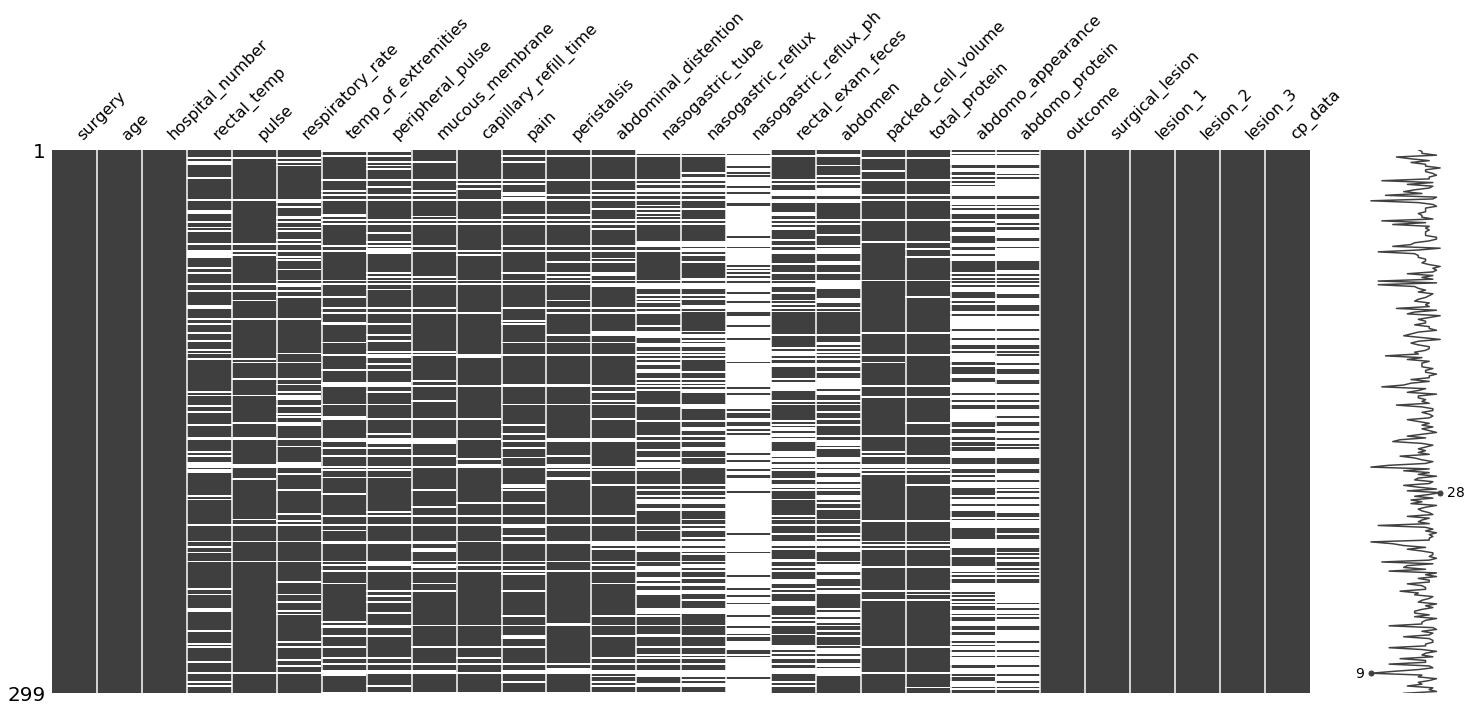

In [8]:
# visualize missing data
msno.matrix(colic)

### Remove Columns

Remove columns with more than 50% missing data, lesion type, and pathology

In [9]:
colic_2 = colic.drop(columns = ['hospital_number','nasogastric_reflux_ph', 'abdomo_appearance',
                      'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3', 'cp_data' ])

### Look at Distributions

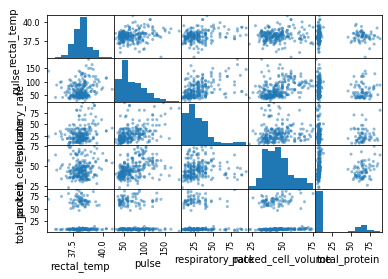

In [10]:
df = colic_2[['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']]
pd.plotting.scatter_matrix(df)
plt.show()

## Impute Data

### capillary_refill_time

In [11]:
# capillary_refill_time has 3 for two values let's replace  
colic_2['capillary_refill_time'].value_counts()

less_3_sec    187
more_3_sec     78
3               2
Name: capillary_refill_time, dtype: int64

In [12]:
# fill 3 in as NA
colic_2['capillary_refill_time'] = colic_2['capillary_refill_time'].replace({'3': np.nan})

### Impute Categorical Variables with Most Common

In [13]:
colic_2.fillna(colic_2.select_dtypes(include = 'object').mode().iloc[0], inplace = True)

### Impute Numeric Variables with Median

In [14]:
colic_2.fillna(colic_2.select_dtypes(include = 'number').median().iloc[0], inplace = True)

## Encode Categorical Variables

In [15]:
# encode binary variables
colic_2['surgery'] = colic_2['surgery'].map({'yes': 1, 'no': 0})
colic_2['age'] = colic_2['age'].map({'young': 1, 'adult': 0})
colic_2['surgical_lesion'] = colic_2['surgical_lesion'].map({'yes': 1, 'no': 0})
colic_2['capillary_refill_time'] = colic_2['capillary_refill_time'].map({'more_3_sec': 1, 'less_3_sec': 0})


In [16]:
# encode ordinal variables
enc = OrdinalEncoder()
colic_2[['temp_of_extremities','peripheral_pulse','pain','peristalsis']] = enc.fit_transform(colic_2[
    ['temp_of_extremities','peripheral_pulse','pain','peristalsis']]) 

colic_2[['abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces']] = enc.fit_transform(colic_2[
    ['abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces']])


In [17]:
# encode nominal variables
colic_2 = pd.get_dummies(colic_2, prefix = ['mucous_membrane', 'abdomen'], columns = ['mucous_membrane', 'abdomen'])

In [18]:
# recode euthanized as died 
colic_2['outcome'] = colic_2['outcome'].replace({'euthanized': 'died'})

In [19]:
colic_2['outcome'].value_counts()

lived    178
died     121
Name: outcome, dtype: int64

In [20]:
colic_2.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,peristalsis,...,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other
0,0,0,38.5,66.0,28.0,1.0,3.0,1,2.0,0.0,...,0,0,1,0,0,1,0,0,0,0
1,1,0,39.2,88.0,20.0,1.0,2.0,0,3.0,0.0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,38.3,40.0,24.0,2.0,2.0,0,3.0,2.0,...,0,0,0,0,1,0,0,0,1,0
3,1,1,39.1,164.0,84.0,0.0,2.0,1,1.0,0.0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,37.3,104.0,35.0,1.0,2.0,1,3.0,2.0,...,0,1,0,0,0,1,0,0,0,0


## Train/ Test Split

In [21]:
# get x and y
y = colic_2['outcome'].copy()
X = colic_2.drop('outcome', axis = 1).copy()

In [22]:
# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 4, stratify=y)

## Standardize

In [23]:
# copy of datasets
X_train_stand = x_train.copy()
X_test_stand = x_test.copy()

# numerical features
num_cols = ['rectal_temp','pulse','respiratory_rate',
            'packed_cell_volume','total_protein']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [24]:
y_test.value_counts()/ 75

lived    0.6
died     0.4
Name: outcome, dtype: float64

## kNN

In [25]:
kNN_classifier = KNeighborsClassifier(n_neighbors=5)
kNN_classifier.fit(X_train_stand, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [26]:
y_pred = kNN_classifier.predict(X_test_stand)

In [27]:
print(confusion_matrix(y_test, y_pred))

[[20 10]
 [ 8 37]]


In [28]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

        died       0.71      0.67      0.69        30
       lived       0.79      0.82      0.80        45

    accuracy                           0.76        75
   macro avg       0.75      0.74      0.75        75
weighted avg       0.76      0.76      0.76        75

0.76


In [29]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_stand, y_train)
    pred_i = knn.predict(X_test_stand)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

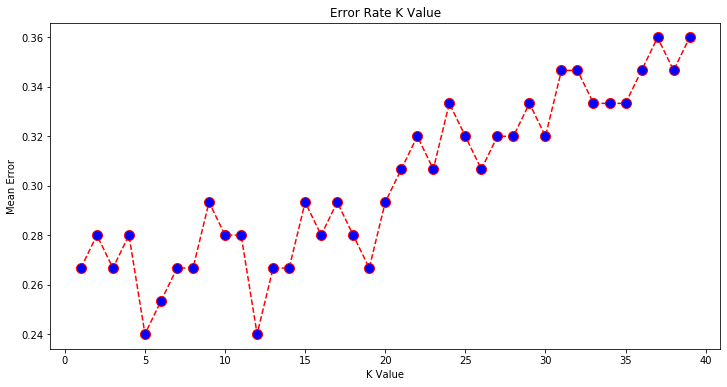

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

## Logistic Regression

In [31]:
logistic_regression = LogisticRegression(solver = 'liblinear', C = 10.0)

In [32]:
logistic_regression.fit(X_train_stand, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred = logistic_regression.predict(X_test_stand)

In [34]:
print(confusion_matrix(y_test, y_pred))

[[19 11]
 [11 34]]


In [35]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

        died       0.63      0.63      0.63        30
       lived       0.76      0.76      0.76        45

    accuracy                           0.71        75
   macro avg       0.69      0.69      0.69        75
weighted avg       0.71      0.71      0.71        75

0.7066666666666667


Feature: 0, Score: 0.70703
Feature: 1, Score: -0.64943
Feature: 2, Score: 0.39104
Feature: 3, Score: -0.16302
Feature: 4, Score: 0.06543
Feature: 5, Score: 0.66687
Feature: 6, Score: 0.76002
Feature: 7, Score: -0.40463
Feature: 8, Score: -0.13217
Feature: 9, Score: 0.18413
Feature: 10, Score: 0.14195
Feature: 11, Score: 0.42755
Feature: 12, Score: 0.34120
Feature: 13, Score: 0.16258
Feature: 14, Score: -0.70335
Feature: 15, Score: 0.37598
Feature: 16, Score: -1.87108
Feature: 17, Score: -0.21127
Feature: 18, Score: -2.07048
Feature: 19, Score: 0.43800
Feature: 20, Score: 0.38053
Feature: 21, Score: -0.59329
Feature: 22, Score: 0.47103
Feature: 23, Score: -1.38284
Feature: 24, Score: 0.03199
Feature: 25, Score: 0.07698
Feature: 26, Score: -1.60154
Feature: 27, Score: 1.28994


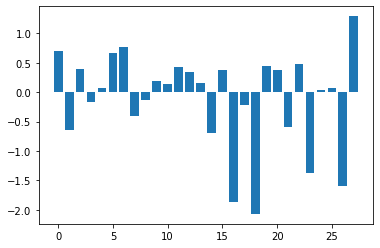

In [36]:
# get importance
log_importance = logistic_regression.coef_[0]
for i,v in enumerate(log_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(log_importance))], log_importance)
plt.show()

## Random Forest

In [37]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_features = 'log2', random_state=65)
rf_classifier.fit(X_train_stand, y_train)
rf_y_pred = rf_classifier.predict(X_test_stand)

In [38]:
print(confusion_matrix(y_test,rf_y_pred))
print(classification_report(y_test,rf_y_pred))
print(accuracy_score(y_test, rf_y_pred))

[[20 10]
 [ 9 36]]
              precision    recall  f1-score   support

        died       0.69      0.67      0.68        30
       lived       0.78      0.80      0.79        45

    accuracy                           0.75        75
   macro avg       0.74      0.73      0.73        75
weighted avg       0.75      0.75      0.75        75

0.7466666666666667


Feature: 0, Score: 0.02261
Feature: 1, Score: 0.01023
Feature: 2, Score: 0.06852
Feature: 3, Score: 0.12848
Feature: 4, Score: 0.07186
Feature: 5, Score: 0.05947
Feature: 6, Score: 0.03021
Feature: 7, Score: 0.03208
Feature: 8, Score: 0.04038
Feature: 9, Score: 0.03116
Feature: 10, Score: 0.03260
Feature: 11, Score: 0.02397
Feature: 12, Score: 0.02613
Feature: 13, Score: 0.02612
Feature: 14, Score: 0.13294
Feature: 15, Score: 0.08746
Feature: 16, Score: 0.05133
Feature: 17, Score: 0.00781
Feature: 18, Score: 0.01525
Feature: 19, Score: 0.00893
Feature: 20, Score: 0.02126
Feature: 21, Score: 0.01552
Feature: 22, Score: 0.01312
Feature: 23, Score: 0.01484
Feature: 24, Score: 0.01537
Feature: 25, Score: 0.00214
Feature: 26, Score: 0.00695
Feature: 27, Score: 0.00324


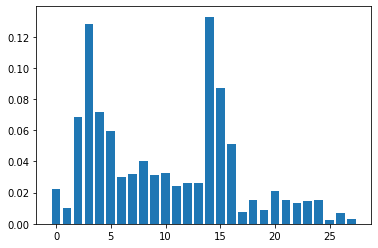

In [39]:
rf_importance = rf_classifier.feature_importances_
for i,v in enumerate(rf_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(rf_importance))], rf_importance)
plt.show()

## Decision Tree

In [40]:
dt_classifier = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3, random_state=30)
dt_classifier.fit(X_train_stand, y_train)
dt_y_pred = dt_classifier.predict(X_test_stand)

In [41]:
print(confusion_matrix(y_test,dt_y_pred))
print(classification_report(y_test,dt_y_pred))
print(accuracy_score(y_test, dt_y_pred))

[[14 16]
 [ 6 39]]
              precision    recall  f1-score   support

        died       0.70      0.47      0.56        30
       lived       0.71      0.87      0.78        45

    accuracy                           0.71        75
   macro avg       0.70      0.67      0.67        75
weighted avg       0.71      0.71      0.69        75

0.7066666666666667


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.47272
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.04976
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.41939
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.05814
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000


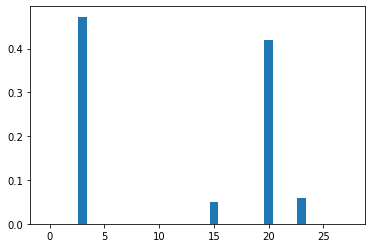

In [42]:
dt_importance = dt_classifier.feature_importances_
for i,v in enumerate(dt_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(dt_importance))], dt_importance)
plt.show()

## Gradient Boosted Trees

In [43]:
model = GradientBoostingClassifier(n_estimators = 100, max_features="sqrt", random_state=30)
model.fit(X_train_stand, y_train)
gb_y_pred = model.predict(X_test_stand)

In [44]:
print(confusion_matrix(y_test,gb_y_pred))
print(classification_report(y_test,gb_y_pred))
print(accuracy_score(y_test, gb_y_pred))

[[20 10]
 [ 7 38]]
              precision    recall  f1-score   support

        died       0.74      0.67      0.70        30
       lived       0.79      0.84      0.82        45

    accuracy                           0.77        75
   macro avg       0.77      0.76      0.76        75
weighted avg       0.77      0.77      0.77        75

0.7733333333333333


Overall I'm happy with how my models performed. I'm working on improving my python and ML, so this was a nice way to get my feet wet. 